In [49]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
df = pd.read_csv('/content/drive/My Drive/merged_XGB_data.csv')


In [51]:
X = df.drop('target', axis=1)
y = df['target']
# X are the features Y  the labl to predict

In [52]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Train set: (21275, 710)
Test set: (5319, 710)


we aply pca first to reduce the dimensionality of the dataset

In [53]:
pca_full = PCA()
pca_full.fit(X_train)

# Visualiser la variance expliquée
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1

print(f"\nComposantes pour 90% variance: {n_components_90}")
print(f"Composantes pour 95% variance: {n_components_95}")


Composantes pour 90% variance: 1
Composantes pour 95% variance: 7


In [54]:
n_components = 200

In [55]:
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
joblib.dump(pca, '/content/drive/My Drive/pca_model.pkl')

['/content/drive/My Drive/pca_model.pkl']

In [56]:
print(f"Shape après PCA: {X_train_pca.shape}")
print(f"Variance totale expliquée: {pca.explained_variance_ratio_.sum():.4f}")

Shape après PCA: (21275, 200)
Variance totale expliquée: 0.9999


test of xgboost training

In [57]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nScale pos weight: {scale_pos_weight:.2f}")

# Paramètres de base
base_params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'auc'],
    'tree_method': 'hist',
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42
}



Scale pos weight: 0.95


In [58]:
# param_grid = {
#     'max_depth': [30, 50, 100],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [150, 300],
#     'min_child_weight': [ 3, 5],
#     'subsample': [0.8],
#     'colsample_bytree': [0.8],
#     'gamma': [0, 0.1, 0.2]
# }


In [59]:
# # tscv = TimeSeriesSplit(n_splits=15)

# # Modèle de base pour grid search
# xgb_model = xgb.XGBClassifier(**base_params,(
#     **base_params,
#     max_depth=70,
#     learning_rate=0.025,
#     n_estimators=250,
#     min_child_weight=3,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     gamma=0.025,
#     early_stopping_rounds=50
# ))

In [60]:
# print("\nRecherche des meilleurs hyperparamètres...")
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     cv=tscv,
#     scoring='roc_auc',
#     n_jobs=-1,
#     # verbose=1
# )

execute grid search

In [61]:
# grid_search.fit(X_train_pca, y_train)
# best_params = grid_search.best_params_
# print(f"\nMeilleurs paramètres: {best_params}")

In [62]:
final_model = xgb.XGBClassifier(
    **base_params,
    max_depth=70,
    learning_rate=0.025,
    n_estimators=250,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.025,
    early_stopping_rounds=50
)

# Entraînement avec validation
eval_set = [(X_train_pca, y_train), (X_test_pca, y_test)]
final_model.fit(
    X_train_pca,
    y_train,
    eval_set=eval_set,
    verbose=50
)

[0]	validation_0-logloss:0.68513	validation_0-auc:0.81634	validation_1-logloss:0.69299	validation_1-auc:0.50935
[50]	validation_0-logloss:0.40657	validation_0-auc:1.00000	validation_1-logloss:0.69520	validation_1-auc:0.51105
[100]	validation_0-logloss:0.26867	validation_0-auc:1.00000	validation_1-logloss:0.69715	validation_1-auc:0.51410
[143]	validation_0-logloss:0.20082	validation_0-auc:1.00000	validation_1-logloss:0.70005	validation_1-auc:0.51024


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=['logloss', 'auc'],
              feature_types=None, feature_weights=None, gamma=0.025,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=70, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, ...)


RÉSULTATS DU MODÈLE
Accuracy: 0.5217
ROC-AUC: 0.5151

Classification Report:
              precision    recall  f1-score   support

        Down       0.50      0.42      0.46      2532
          Up       0.54      0.61      0.57      2787

    accuracy                           0.52      5319
   macro avg       0.52      0.52      0.51      5319
weighted avg       0.52      0.52      0.52      5319



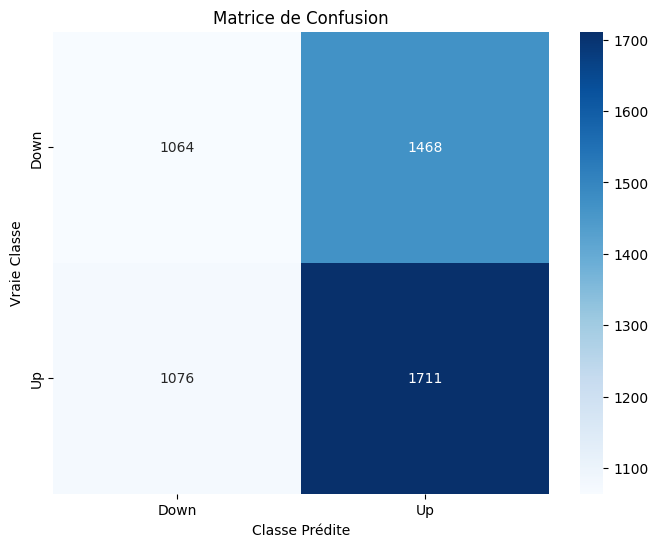

In [63]:
# Prédictions
y_pred = final_model.predict(X_test_pca)
y_pred_proba = final_model.predict_proba(X_test_pca)[:, 1]

# Métriques
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n" + "="*50)
print("RÉSULTATS DU MODÈLE")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Matrice de Confusion')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()



In [64]:
booster = final_model.get_booster()
booster.save_model("/content/drive/MyDrive/final_xgb_pca.json")

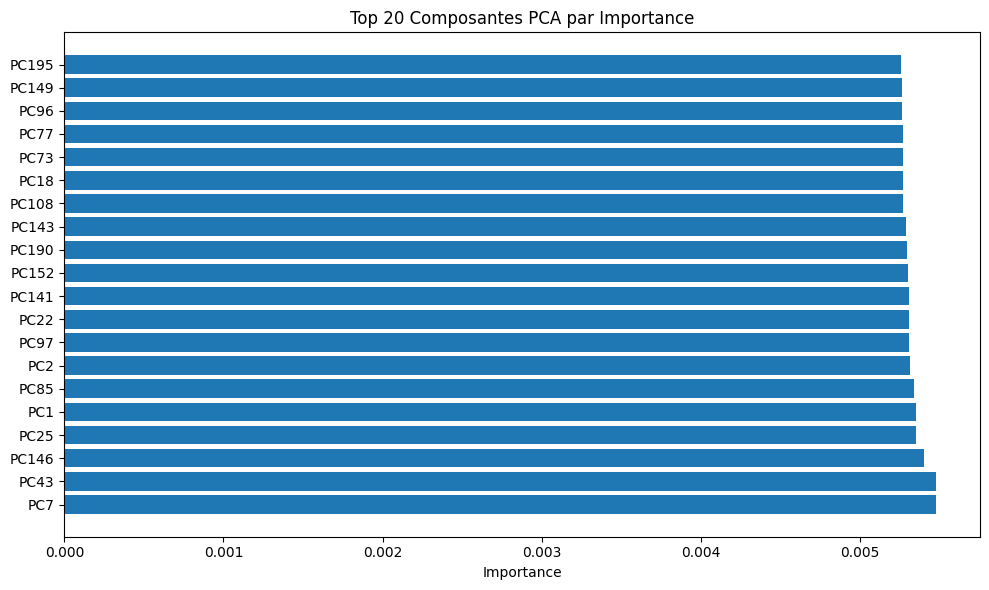

In [65]:
# Feature importance (basé sur composantes PCA)
importance_df = pd.DataFrame({
    'component': [f'PC{i+1}' for i in range(n_components)],
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['component'][:20], importance_df['importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Composantes PCA par Importance')
plt.tight_layout()
plt.show()